In [1]:
 import datetime
import pandas as pd
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as pyplot

In [1]:
# 1. Import libraries and test up connection

In [5]:
from google.cloud import aiplatform
from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value
from google.cloud.aiplatform_v1.types import (
    DeployedModel, ExplanationMetadata,ExplanationParameters,ExplanationSpec,InputDataConfig,Model,ModelContainerSpec,Port, PredictRequest
)
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np

# Set the project and location
PROJECT_ID = "hale-brook-377621"
LOCATION = "us-central1"

# Set the name and location of the dataset file
DATASET_PATH = "gs://dembucket/DEM_Challenge_Section1_DATASET.xlsx - DATA.csv"

# Create a Vertex AI client
client_options = {"api_endpoint": f"{LOCATION}-aiplatform.googleapis.com"}
client = aiplatform.gapic.JobServiceClient(client_options=client_options)

# Load the dataset
df = pd.read_csv(DATASET_PATH)


In [6]:
print(sorted(df.columns))
print(df.shape)

['email', 'first_name', 'gender', 'id', 'ip_address', 'last_name']
(1000, 6)


In [7]:
df.head(3)

,id,first_name,last_name,email,gender,ip_address
0,1,Margaretta,Laughtisse,mlaughtisse0@mediafire.com,Genderfluid,34.148.232.131
1,2,Vally,Garment,vgarment1@wisc.edu,Bigender,15.158.123.36
2,3,Tessa,Curee,tcuree2@php.net,Bigender,132.209.143.225


In [ ]:
# 2. Feature extraction from IP addresses

In [9]:
src_ip_df = df['ip_address'].copy()

src_ip_df = src_ip_df.reset_index()

# Drop missing items from both data frames
src_ip_df = src_ip_df.dropna().copy()


# Drop duplicates
src_ip_df=src_ip_df.drop_duplicates(['ip_address'])

print(src_ip_df.shape)
src_ip_df.head(5)
src_ip_df.loc[:, 'oct1'] = src_ip_df['ip_address'].apply(lambda x: x.split(".")[0])
src_ip_df.loc[:, 'oct2'] = src_ip_df['ip_address'].apply(lambda x: x.split(".")[1])
src_ip_df.loc[:, 'oct3'] = src_ip_df['ip_address'].apply(lambda x: x.split(".")[2])
src_ip_df.loc[:, 'oct4'] = src_ip_df['ip_address'].apply(lambda x: x.split(".")[3])
src_ip_df = src_ip_df.reset_index()
print(src_ip_df.head(5))

(1000, 2)
   level_0  index       ip_address oct1 oct2 oct3 oct4
0        0      0   34.148.232.131   34  148  232  131
1        1      1    15.158.123.36   15  158  123   36
2        2      2  132.209.143.225  132  209  143  225
3        3      3   157.110.61.233  157  110   61  233
4        4      4     49.55.218.81   49   55  218   81


In [10]:
src_ip_df=src_ip_df.drop(['index'], axis = 1)
X_matrix_src = np.array(src_ip_df[['oct1', 'oct2', 'oct3', 'oct4']])
print(X_matrix_src.shape)
print(X_matrix_src[0:5])
print()

(1000, 4)
[['34' '148' '232' '131']
 ['15' '158' '123' '36']
 ['132' '209' '143' '225']
 ['157' '110' '61' '233']
 ['49' '55' '218' '81']]



In [ ]:
#3. Let's apply PCA to reduce the dimensions for cluster visualization

In [11]:
from sklearn.decomposition import PCA

# source
pcas = PCA(n_components=4)
pcas.fit(X_matrix_src)
print(pcas.explained_variance_ratio_)


[0.28137549 0.2516849  0.23630022 0.23063939]


In [12]:
pca_src = PCA(n_components=2)
pcas = pca_src.fit_transform(X_matrix_src)

pcas1=[]
pcas2=[]

#source
for i in pcas:
    pcas1.append(i[0])
    pcas2.append(i[1])
    
print(len(pcas1))
print(len(pcas2))


1000
1000


   level_0      ip_address oct1 oct2 oct3 oct4        pca1        pca2
0        0  34.148.232.131   34  148  232  131 -110.737651   23.137985
1        1   15.158.123.36   15  158  123   36  -28.086457  130.277664



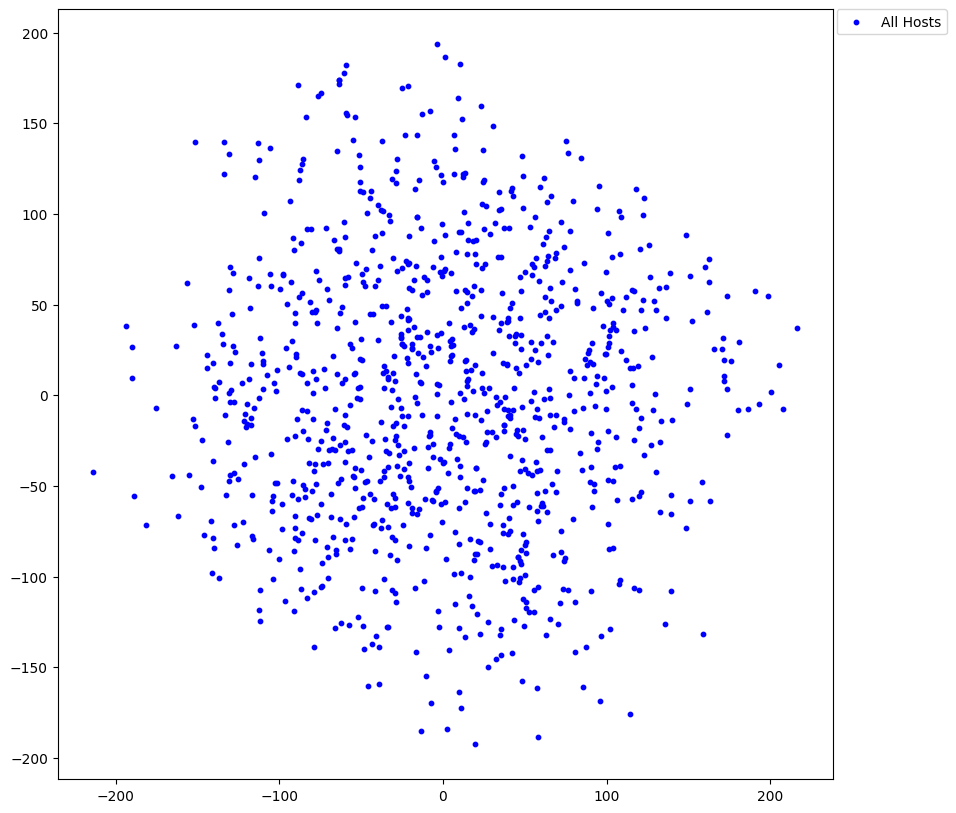

In [13]:
#Store the two principal components as new features in the source and destination data frames.
src_ip_df['pca1'] = pcas1
src_ip_df['pca2'] = pcas2
print(src_ip_df[:2])
print()

# Maintain a copy for using for K-Means later.
src_ip_df_copy = src_ip_df.copy()

#Scatter plot of Source IP address data
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10,10)
plt.scatter(src_ip_df['pca1'], src_ip_df['pca2'], s=10, color='blue',label="All Hosts")
plt.legend(bbox_to_anchor=(1.005, 1), loc=2, borderaxespad=0.)
plt.show()

In [ ]:
#4. Use Gaussian Mixture Modeling (GMM) Clustering algorithm to group similar IP addresses.
#Use BayesianGaussianMixture to determine first the optimum number of clusters that can be formed.

In [14]:
from sklearn.mixture import BayesianGaussianMixture

# Check 7 clusters
bgms = BayesianGaussianMixture(n_components=7, n_init=10, random_state=100)

bgms.fit(X_matrix_src)
np.round(bgms.weights_, 2)

/opt/conda/lib/python3.7/site-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,


array([0.15, 0.09, 0.25, 0.16, 0.16, 0.12, 0.07])

In [ ]:
#BayesianGaussianMixture gives weights of each cluster. 
#We see that few of the clusters have been eliminated with near 0 weight. So we can try 5 clusters on the data.

In [15]:
bgms = BayesianGaussianMixture(n_components=5, n_init=10, random_state=100)
bgms.fit(X_matrix_src)
print(np.round(bgms.weights_, 2))

[0.19 0.28 0.15 0.24 0.14]


In [16]:
print(bgms.means_)
pca_means = pca_src.transform(bgms.means_)
print()
print(pca_means)

[[144.84839153 137.92964866  34.41871483 116.53792874]
 [130.2048704   69.90685582 148.30467159  86.19192651]
 [199.25217803 197.18622053 162.54967242 106.74318226]
 [121.40053125 111.34571149 140.62726857 213.06679548]
 [ 60.60993651 204.60764642 153.91038614 104.27151195]]

[[ 57.84124713  24.03058385]
 [ 41.57617842   4.8861154 ]
 [-18.2194636   14.07832804]
 [-33.1831613  -75.02267874]
 [-79.05007829  72.58254996]]


In [17]:
means_df_s = pd.DataFrame(pca_means, columns=['pca1','pca2'])
means_df_s

,pca1,pca2
0,57.841247,24.030584
1,41.576178,4.886115
2,-18.219464,14.078328
3,-33.183161,-75.022679
4,-79.050078,72.582550


In [18]:
print(bgms.converged_)
print(bgms.n_iter_)

True
100


In [19]:
#Predict the clusters for the IP addresses and note it in a separate column
bgms.predict(X_matrix_src)

array([4, 4, 3, 3, 1, 4, 0, 0, 3, 3, 1, 0, 0, 3, 2, 1, 3, 3, 3, 3, 4, 2,
       1, 4, 0, 2, 3, 4, 3, 4, 1, 4, 0, 1, 4, 2, 4, 0, 3, 0, 0, 0, 1, 4,
       2, 2, 4, 3, 3, 0, 3, 4, 0, 4, 3, 2, 0, 4, 4, 1, 3, 2, 3, 1, 2, 2,
       2, 1, 4, 3, 4, 0, 2, 4, 3, 4, 4, 4, 0, 0, 2, 1, 2, 2, 3, 3, 4, 2,
       2, 1, 4, 3, 0, 1, 1, 2, 2, 2, 1, 4, 3, 0, 3, 2, 4, 4, 0, 3, 1, 1,
       3, 4, 0, 0, 3, 3, 0, 1, 3, 3, 2, 2, 1, 4, 0, 1, 3, 1, 4, 1, 2, 1,
       2, 0, 0, 3, 1, 4, 0, 1, 3, 1, 0, 2, 1, 0, 2, 0, 3, 3, 3, 2, 1, 0,
       0, 0, 1, 4, 1, 4, 4, 0, 2, 3, 2, 0, 2, 0, 1, 0, 0, 0, 0, 1, 3, 1,
       3, 1, 0, 1, 3, 0, 3, 1, 1, 1, 3, 2, 3, 2, 2, 3, 1, 3, 1, 1, 3, 0,
       2, 2, 0, 1, 1, 3, 0, 3, 3, 1, 3, 1, 0, 1, 0, 2, 1, 1, 1, 1, 1, 0,
       4, 0, 1, 0, 0, 2, 3, 2, 0, 2, 4, 1, 1, 3, 1, 2, 1, 1, 3, 3, 1, 4,
       4, 3, 4, 0, 2, 1, 1, 2, 3, 3, 2, 0, 2, 3, 1, 1, 1, 3, 2, 4, 3, 3,
       3, 3, 1, 1, 1, 0, 2, 1, 3, 0, 1, 3, 1, 3, 0, 2, 3, 0, 1, 1, 2, 4,
       3, 0, 0, 0, 3, 1, 1, 1, 3, 3, 1, 4, 2, 3, 0,

In [20]:
src_ip_df['kcluster']=bgms.predict(X_matrix_src).tolist()
src_ip_df.tail(10)

,level_0,ip_address,oct1,oct2,oct3,oct4,pca1,pca2,kcluster
990,990,89.57.32.247,89,57,32,247,29.639916,-94.098894,3
991,991,7.246.81.44,7,246,81,44,-63.802038,171.646887,4
992,992,212.111.15.217,212,111,15,217,74.222890,-89.974945,0
993,993,197.146.36.155,197,146,36,155,60.269100,-23.288775,0
994,994,70.137.63.180,70,137,63,180,-15.988833,-4.542297,3
995,995,227.67.205.244,227,67,205,244,-7.054649,-169.642971,3
996,996,189.120.124.155,189,120,124,155,24.218534,-46.917930,1
997,997,246.169.244.242,246,169,244,242,-78.857326,-138.702316,3
998,998,16.201.179.189,16,201,179,189,-144.342985,15.060518,4
999,999,0.14.221.255,0,14,221,255,-90.716881,-118.984723,3


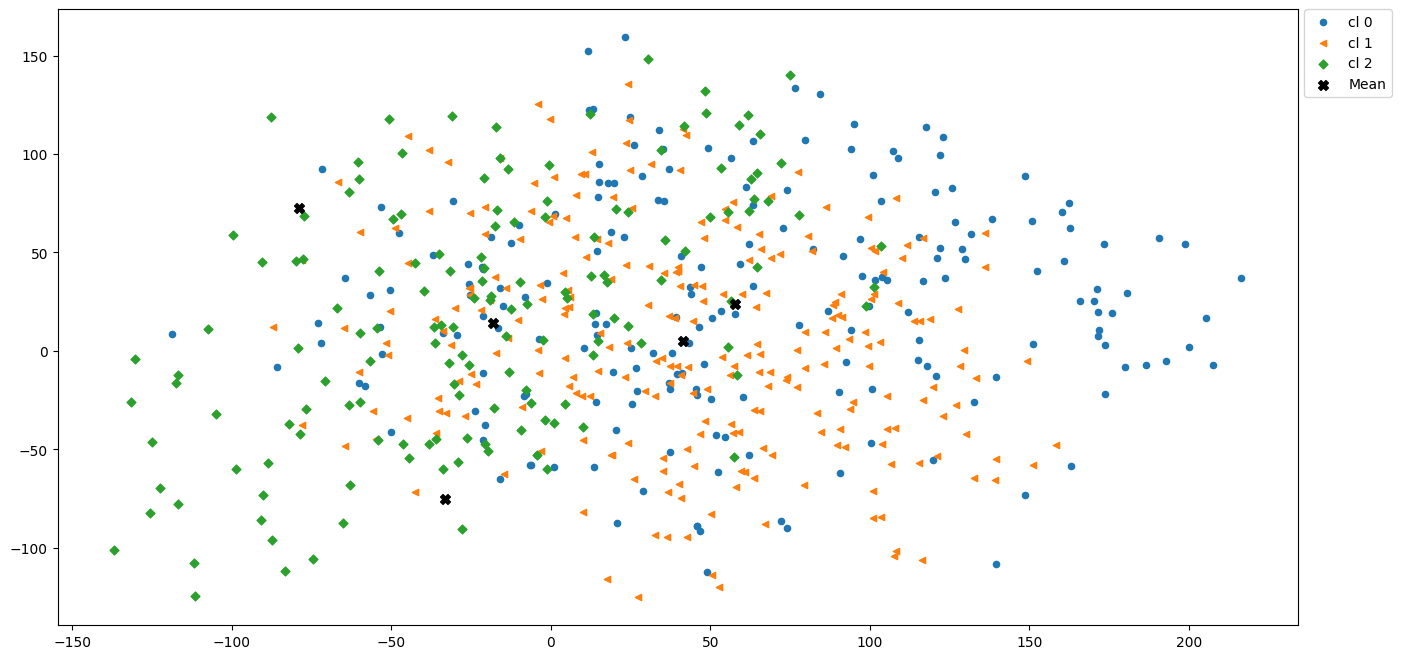

In [23]:
#Plot the clusters identified by GMM
dfs0=src_ip_df[src_ip_df.kcluster==0]
dfs1=src_ip_df[src_ip_df.kcluster==1]
dfs2=src_ip_df[src_ip_df.kcluster==2]
plt.rcParams["figure.figsize"] = (16,8)
pyplot.scatter(dfs0['pca1'],dfs0['pca2'],s=20,label="cl 0")
pyplot.scatter(dfs1['pca1'],dfs1['pca2'],s=20,marker="<",label="cl 1")
pyplot.scatter(dfs2['pca1'],dfs2['pca2'],s=20,marker="D",label="cl 2")
pyplot.scatter(means_df_s['pca1'],means_df_s['pca2'],s=50,marker="X",label="Mean", color='black')

pyplot.legend(bbox_to_anchor=(1.005, 1), loc=2, borderaxespad=0.)
pyplot.show()